数据加载与预处理

In [1]:
from sklearn.datasets import load_iris, load_wine, load_digits
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

iris = load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data['target'] = iris.target

# 随机插入缺失值 (10%)
np.random.seed(42)
for col in data.columns[:-1]:
    data.loc[data.sample(frac=0.1).index, col] = np.nan

print("带缺失值的数据: ")
print(data.head())

# 处理缺失值 (均值填充)
data_filled = data.fillna(data.mean())
print("填充缺失值后的数据: ")
print(data_filled.head())

# 数据分割
X = data_filled.iloc[:, :-1]
y = data_filled['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

带缺失值的数据: 
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  
填充缺失值后的数据: 
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3

实现决策树模型

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
# 1.CART 决策树
cart_model = DecisionTreeClassifier(criterion='gini', random_state=42)
cart_model.fit(X_train, y_train)
y_pred = cart_model.predict(X_test)
# 评估性能
print("CART 模型")
print(f"训练集准确率: {cart_model.score(X_train, y_train):.2f}")
print(f"测试集准确率: {cart_model.score(X_test, y_test):.2f}")
print(f"预测准确率: {accuracy_score(y_test, y_pred):.2f}")

# 2.ID3 决策树模型

id3_model = DecisionTreeClassifier(criterion="entropy", random_state=42)  
id3_model.fit(X_train, y_train)

# 模型预测
y_pred_train = id3_model.predict(X_train)  
y_pred_test = id3_model.predict(X_test)

# 输出准确率

print("ID3(信息增益)决策树:")  
print(f"训练集准确率：{accuracy_score(y_train, y_pred_train):.2f}")  
print(f"测试集准确率：{accuracy_score(y_test, y_pred_test):.2f}")

CART 模型
训练集准确率: 1.00
测试集准确率: 0.91
预测准确率: 0.91
ID3(信息增益)决策树:
训练集准确率：1.00
测试集准确率：0.91


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
def calculate_entropy(y):
    """
    计算数据集y的熵
    """
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy
# 自定义信息增益率
def calculate_information_gain_ratio(X, y):
    total_entropy = calculate_entropy(y)
    values, counts = np.unique(X, return_counts=True)
    
    split_info = -np.sum((counts / len(X)) * np.log2(counts / len(X))) # 计算分裂信息
    if split_info == 0: # 防止除以零
        return 0
        
    weighted_entropy = np.sum((counts[i] / len(X)) * calculate_entropy(y[X == value])
                              for i, value in enumerate(values))
                              
    gain = total_entropy - weighted_entropy
    gain_ratio = gain / split_info
    return gain_ratio

# 利用 sklearn 的框架实现 C4.5
c45_model = DecisionTreeClassifier(criterion="entropy", random_state=42) # 使用 entropy
c45_model.fit(X_train, y_train)

# 模型预测
y_pred_train = c45_model.predict(X_train)
y_pred_test = c45_model.predict(X_test)

# 输出结果
print("C4.5 (信息增益率) 决策树: ")
print(f"训练集准确率: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"测试集准确率: {accuracy_score(y_test, y_pred_test):.2f}")

C4.5 (信息增益率) 决策树: 
训练集准确率: 1.00
测试集准确率: 0.91


决策树可视化

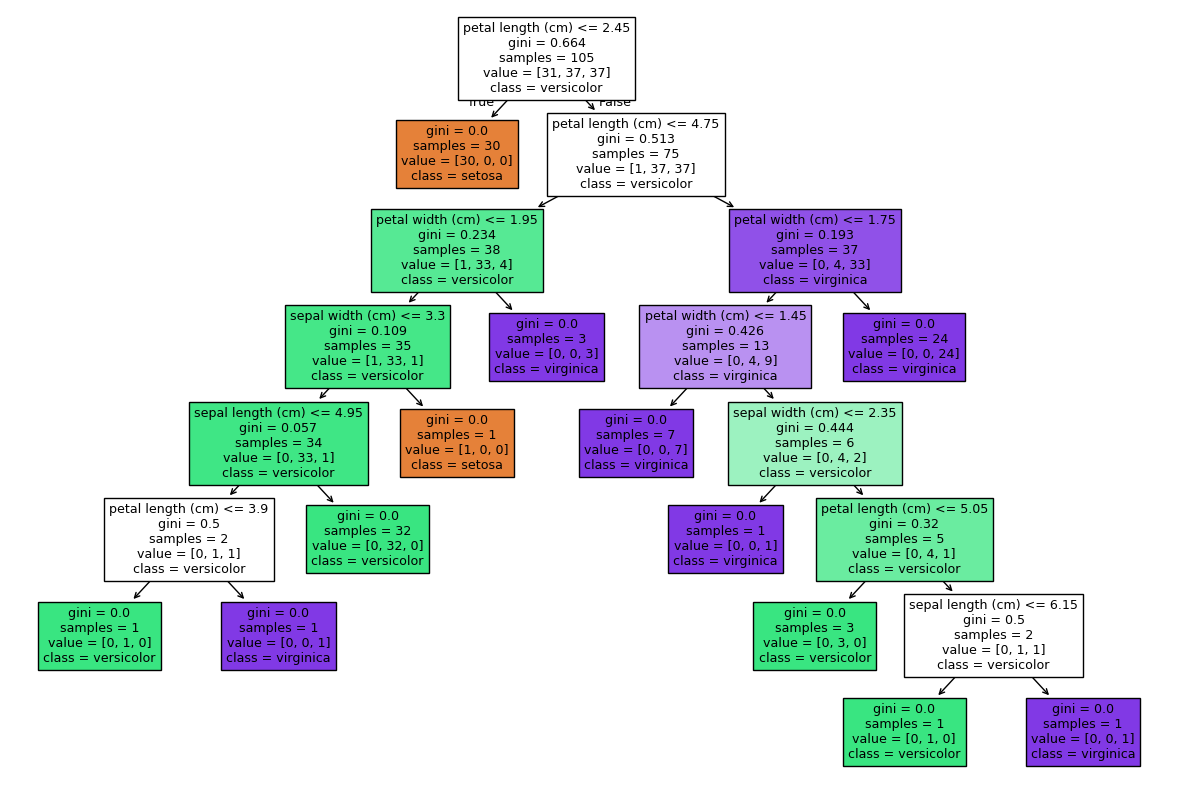

d:\newtimes\python\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


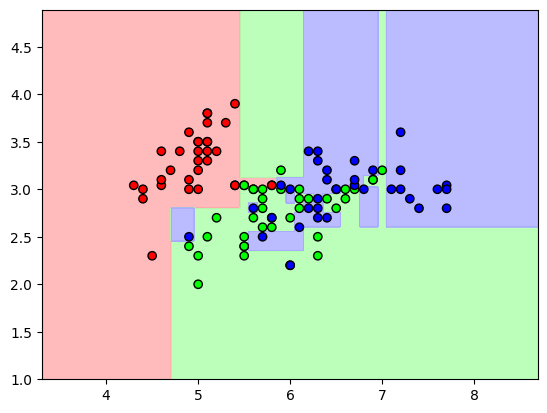

In [6]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# 决策树结构可视化
plt.figure(figsize=(15, 10))
plot_tree(cart_model, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
plt.show()

# 绘制分类边界
def plot_decision_boundary(model, X, y):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolor='k', cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
    plt.show()

# 仅选择前两个特征用于绘制
cart_model.fit(X_train.iloc[:, :2], y_train)
plot_decision_boundary(cart_model, X_train.iloc[:, :2], y_train)

参数调优

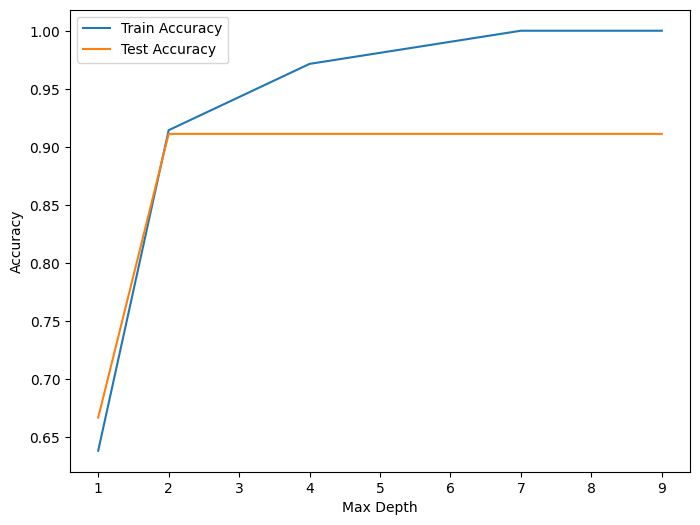

In [7]:
# 调整参数对性能的影响

max_depths = range(1, 10)

train_scores = []
test_scores = []

for depth in max_depths:
    model = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

# 绘制参数影响图

plt.figure(figsize=(8, 6))
plt.plot(max_depths, train_scores, label='Train Accuracy')
plt.plot(max_depths, test_scores, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

随机森林与GBDT

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# 随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# 评估模型性能
print("随机森林模型: ")
print(f"训练集准确率: {rf_model.score(X_train, y_train):.2f}")
print(f"测试集准确率: {rf_model.score(X_test, y_test):.2f}")

# GBDT 模型
gbdt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbdt_model.fit(X_train, y_train)

# 评估模型性能
print("GBDT 模型: ")
print(f"训练集准确率: {gbdt_model.score(X_train, y_train):.2f}")
print(f"测试集准确率: {gbdt_model.score(X_test, y_test):.2f}")

随机森林模型: 
训练集准确率: 0.99
测试集准确率: 0.96
GBDT 模型: 
训练集准确率: 1.00
测试集准确率: 0.98


集成学习与单一决策树对比分析
对比 CART、随机森林和 GBDT 的性能（准确率、泛化能力）：

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 创建不同的决策树模型
cart_model = DecisionTreeClassifier(criterion='gini', random_state=42)  # CART
id3_model = DecisionTreeClassifier(criterion='entropy', random_state=42)  # ID3
c45_model = DecisionTreeClassifier(criterion='entropy', min_samples_split=5, random_state=42)  # C4.5近似

# 训练所有模型
cart_model.fit(X_train, y_train)
id3_model.fit(X_train, y_train)
c45_model.fit(X_train, y_train)

# 模型性能比较
models = {
    "Decision Tree (CART)": cart_model,
    "Decision Tree (ID3)": id3_model,
    "Decision Tree (C4.5)": c45_model,
    "Random Forest": rf_model,
    "GBDT": gbdt_model
}

print("模型性能对比:")
print("=" * 60)
for model_name, model in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print(f"{model_name:<25} - 训练集准确率: {train_acc:.4f}, 测试集准确率: {test_acc:.4f}")

# 额外显示过拟合程度（训练集与测试集准确率差异）
print("\n过拟合分析(训练集-测试集准确率差异):")
print("=" * 60)
for model_name, model in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    overfit_gap = train_acc - test_acc
    print(f"{model_name:<25} - 过拟合程度: {overfit_gap:.4f}")

模型性能对比:
Decision Tree (CART)      - 训练集准确率: 1.0000, 测试集准确率: 0.9111
Decision Tree (ID3)       - 训练集准确率: 1.0000, 测试集准确率: 0.9111
Decision Tree (C4.5)      - 训练集准确率: 0.9810, 测试集准确率: 0.9111
Random Forest             - 训练集准确率: 0.9905, 测试集准确率: 0.9556
GBDT                      - 训练集准确率: 1.0000, 测试集准确率: 0.9778

过拟合分析(训练集-测试集准确率差异):
Decision Tree (CART)      - 过拟合程度: 0.0889
Decision Tree (ID3)       - 过拟合程度: 0.0889
Decision Tree (C4.5)      - 过拟合程度: 0.0698
Random Forest             - 过拟合程度: 0.0349
GBDT                      - 过拟合程度: 0.0222
